In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import *
from fastai import *
from fastai.callbacks.hooks import *

In [0]:
from skimage.transform import rescale,resize
from skimage import data, color

In [0]:
path = untar_data(URLs.PETS); path
bs = 64

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [0]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Siamese_39.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_145.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_175.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_72.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_17.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 96934676.09it/s]


In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


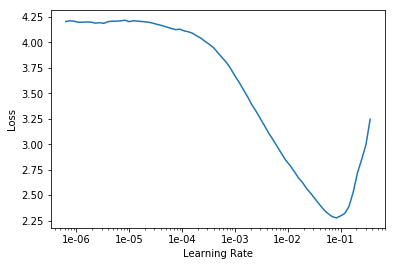

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4,slice(2e-05,2e-02))

epoch,train_loss,valid_loss,accuracy,time
0,0.627382,0.362523,0.890392,01:32
1,0.589058,0.285984,0.909337,01:32
2,0.383697,0.199445,0.935047,01:33
3,0.226549,0.155481,0.947226,01:30


In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


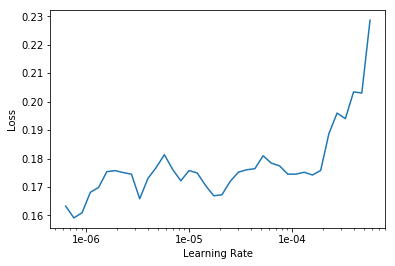

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5,slice(1e-05/9,1e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.183440,0.153318,0.947903,01:39
1,0.168304,0.150911,0.945873,01:37
2,0.160840,0.146522,0.948579,01:37
3,0.159457,0.145973,0.946549,01:39
4,0.156845,0.147261,0.946549,01:39


In [0]:
m = learn.model.eval()

In [0]:
m[0][7][2]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
)

Category shiba_inu

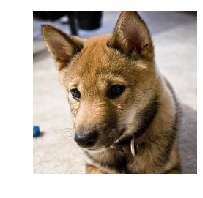

In [0]:
idx = 15
x, y = data.valid_ds[idx]
x.show()
y

In [0]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
class ActGrad(object):
    
    def __init__(self, model, layers):
        self.model = model
        self.layers = layers
        
    def __call__(self, x, cat):
        self.model.zero_grad()
        with hook_output(self.layers) as hook_a: 
            with hook_output(self.layers, grad=True) as hook_g:
                preds = m(x)
                preds[0,int(cat)].backward()
        return hook_a.stored[0].cpu(),hook_g.stored[0][0].cpu() # returns (ch,h,w)

In [0]:
class GradCAM(ActGrad):
    def __init__(self, model, layers):
        super(GradCAM, self).__init__(model,layers)
        
    def __call__(self,x, y):
        acts, grads = ActGrad(self.model,self.layers)(x,y)
        wts = grads.mean((-2,-1)) #global avg pooling
        L = F.relu((wts[...,None,None] * acts).sum(-3)) #saliency map
        L = resize(L,(x.shape[-2],x.shape[-1]),anti_aliasing=True)
        L = (L - L.min())/(L.max() - L.min())
        return np.uint8(L * 255)

In [0]:
sm = GradCAM(m,m[0])(xb,y)

In [0]:
sm.shape

(224, 224)

In [0]:
def show_heatmap(x_im,hm):
    _,ax = plt.subplots()
    x_im.show(ax)
    ax.imshow(hm, alpha=0.6,cmap='jet');

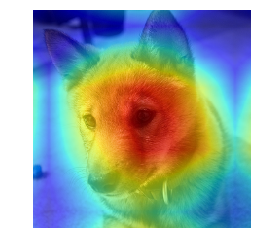

In [0]:
show_heatmap(xb_im,sm)

In [0]:
class GradCAMpp(GradCAM):
    def __init__(self,models,layers):
        super(GradCAMpp,self).__init__(models,layers)
    
    def __call__(self,x,y):
        acts, grads = ActGrad(self.model,self.layers)(x,y)
        alpha_n = grads.pow(2)
        alpha_d = grads.pow(2).mul(2)+ acts.mul(grads.pow(3)).sum((-1,-2),keepdim=True)
        alpha_d = torch.where(alpha_d != 0.0, alpha_d, torch.ones_like(alpha_d))
        alpha = alpha_n.div(alpha_d+1e-7)
        pgrads = F.relu(grads) # F.relu(score.exp()*grads) where score = m(x)[0,int(y)]
        wts = (pgrads * alpha).sum((-1,-2))
        L = F.relu((wts[...,None,None] * acts).sum(-3))
        L = resize(L,(x.shape[-2],x.shape[-1]),anti_aliasing=True)
        L = (L - L.min())/(L.max() - L.min())
        return np.uint8(L * 255)

In [0]:
smp = GradCAMpp(m,m[0])(xb,y)

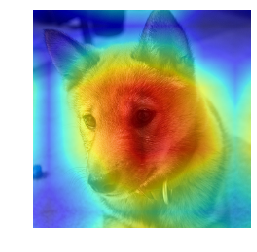

In [0]:
show_heatmap(xb_im,smp)

In [0]:
class GuidedBackprop:
    def __init__(self, model):
        self.model = model
        self.relus = [module[1] for module in self.model.named_modules() if "ReLU(inplace)" == str(module[1])]
        self.hook = Hooks(self.relus, self.clamp_gradients_hook, is_forward=False)
        
    def clamp_gradients_hook(self, module, grad_in, grad_out):
        for grad in grad_in:
            torch.clamp_(grad, min=0.0)
    
    def __call__(self,image,cat):
        image.requires_grad_()
        self.model.zero_grad()
        preds = self.model(image)
        preds[0,int(cat)].backward()
        return image.grad.squeeze().cpu().numpy()
        

In [0]:
grad=GuidedBackprop(m)(xb,y)

In [0]:
grad.shape

(3, 224, 224)

In [0]:
ggcam = (grad*smp)

In [0]:
def grad_to_image(gradient):
    gradient = gradient - gradient.min()
    gradient /= gradient.max()
    gradient = np.uint8(gradient * 255).transpose(1, 2, 0)
    gradient = gradient[..., ::-1]
    return gradient

In [0]:
img_ggcam = grad_to_image(ggcam)

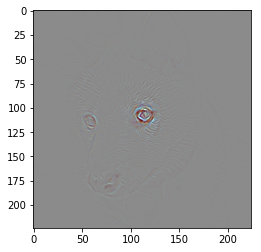

In [0]:
plt.imshow(img_ggcam)

In [0]:
def to_grayscale(tensor_im):
    grayscale_im = np.sum(np.abs(tensor_im), axis=0)
    im_max = np.percentile(grayscale_im, 99)
    im_min = np.min(grayscale_im)
    grayscale_im = np.clip((grayscale_im - im_min) / (im_max - im_min), 0, 1)
    grayscale_im = np.expand_dims(grayscale_im, axis=0)
    return grayscale_im

In [0]:
ggcam_gray = to_grayscale(ggcam)
img_ggcam_gray = np.squeeze(grad_to_image(ggcam_gray))

In [0]:
img_ggcam_gray.shape

(224, 224)

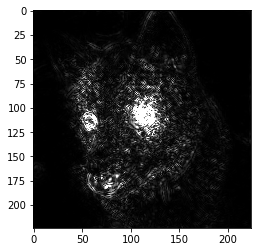

In [0]:
plt.imshow(img_ggcam_gray,cmap="gray")

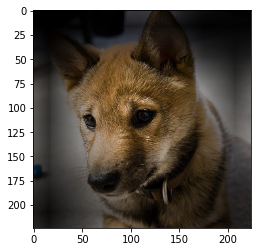

In [0]:
plt.imshow((smp.astype(float)/255.0 * xb_im.data.numpy()).transpose(1,2,0))

In [0]:
def ggcams(grad,sm):
    ggcam = (grad*sm)
    img_ggcam = grad_to_image(ggcam)
    ggcam_gray = to_grayscale(ggcam)
    img_ggcam_gray = np.squeeze(grad_to_image(ggcam_gray))
    return img_ggcam,img_ggcam_gray

In [0]:
def visualize_ims(m,x,x_im,y):
    sm = GradCAM(m,m[0])(x,y)
    smp = GradCAMpp(m,m[0])(x,y)
    grad = GuidedBackprop(m)(x,y)
    img_ggcam_sm, img_ggcam_gray_sm = ggcams(grad,sm)
    img_ggcam_smp, img_ggcam_gray_smp = ggcams(grad,smp)
    fig, axs = plt.subplots(1,5,squeeze=False)
    for i,sm in enumerate([sm]):
        x_im.show(axs[i,1])
        axs[i,1].imshow(sm,alpha=0.6,cmap='jet')
        axs[i,1].set_axis_off()
        img_ggcam, img_ggcam_gray = ggcams(grad,sm)
        axs[i,2].imshow(img_ggcam)
        axs[i,2].set_axis_off()
        axs[i,3].imshow(img_ggcam_gray)
        axs[i,3].set_axis_off()
        axs[i,4].imshow((smp.astype(float)/255.0 * x_im.data.numpy()).transpose(1,2,0))
        axs[i,4].set_axis_off()
    x_im.show(axs[0,0])
    axs[0,0].set_axis_off()
    #axs[1,0].imshow(grad_to_image(grad))
    #axs[1,0].set_axis_off()
    #map(lambda axi: axi.set_axis_off(), axs.ravel())

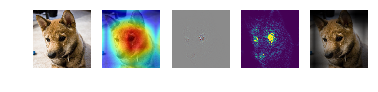

In [0]:
visualize_ims(m,xb,xb_im,y)